In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import tensorflow as tf

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Simple demo neural network classifier:

In [3]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

num_classes = 2

def build_classifier(num_classes, num_dimensions=1781):

    classifier = Sequential([
        Dense(1024, activation='relu', input_shape=(num_dimensions, )),
        Dense(128, activation='relu'),
        Dense(16, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    classifier.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy',])
    return classifier

In [4]:
import numpy as np

with open("counts/SRR_47normal_small.list") as normal_subjects_file:
    healthy_subjects = [line.strip() for line in normal_subjects_file]

with open("counts/SRR_50aml_small.list") as diseased_subjects_file:
    diseased_subjects = [line.strip() for line in diseased_subjects_file]

In [5]:
print(len(healthy_subjects), len(diseased_subjects))

47 50


In [6]:
def load_data(subjects_array, subdirectory="counts_DP8_dbsnp/"):
    a = []
    for person in subjects_array:
        try:
            with open(subdirectory + person + ".count") as person_file:
                vector = [line.strip().split()[-1] for line in person_file]
                a.append(np.array(vector))
        except FileNotFoundError:
            continue
    return a

X_healthy = load_data(healthy_subjects)
y_healthy = [0. for _ in range(len(X_healthy))]
X_diseased = load_data(diseased_subjects)
y_diseased = [1. for _ in range(len(X_diseased))]

In [7]:
print(len(X_healthy), len(X_diseased))
print(len(y_healthy), len(y_diseased))

28 42
28 42


In [8]:
X = np.array(X_healthy + X_diseased)
y = np.array(y_healthy + y_diseased)

In [9]:
num_people = len(X)

One-Hot Encode Output Labels:

In [10]:
from tensorflow.python.keras.utils import to_categorical

y1hot = to_categorical(y, num_classes=num_classes)

## K-Fold Cross Validation
Since we don't have many people represented in our data, we'll do leave-one-out cross validation:

In [11]:
from sklearn.model_selection import KFold
from tensorflow.python.keras.callbacks import ModelCheckpoint

kf = KFold(n_splits=num_people)
fold_number = 1
cvscores = []
for train_index, val_index in kf.split(X):
    print("Fold " + str(fold_number))
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y1hot[train_index], y1hot[val_index]
    classifier = build_classifier(num_classes=num_classes)
    filename = "fold{}.weights.hdf5".format(fold_number)
    model_checkpointer = ModelCheckpoint(filepath=filename, verbose=1, save_best_only=True)
    classifier.fit(X_train, y_train, batch_size=num_people, epochs=8, validation_data=(X_val, y_val), verbose=2, callbacks=[model_checkpointer])
    classifier.load_weights(filename)
    scores = classifier.evaluate(X_val, y_val, verbose=0)
    print(classifier.metrics_names)
    print(scores)
    cvscores.append(scores)
    del classifier
    fold_number += 1

Fold 1
Train on 69 samples, validate on 1 samples
Epoch 1/8
 - 1s - loss: 2.9127 - acc: 0.5507 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00000, saving model to fold1.weights.hdf5
Epoch 2/8
 - 0s - loss: 1.6709 - acc: 0.8116 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve
Epoch 3/8
 - 0s - loss: 5.4047 - acc: 0.6232 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve
Epoch 4/8
 - 0s - loss: 5.9760 - acc: 0.6232 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 5.9901 - acc: 0.6232 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 5.9777 - acc: 0.6232 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 5.9413 - acc: 0.6232 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - lo

Train on 69 samples, validate on 1 samples
Epoch 1/8
 - 1s - loss: 3.2951 - acc: 0.5507 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 16.11810, saving model to fold8.weights.hdf5
Epoch 2/8
 - 0s - loss: 5.6545 - acc: 0.6232 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve
Epoch 3/8
 - 0s - loss: 5.3157 - acc: 0.6232 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve
Epoch 4/8
 - 0s - loss: 3.2118 - acc: 0.7391 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00004: val_loss improved from 16.11810 to 0.00000, saving model to fold8.weights.hdf5
Epoch 5/8
 - 0s - loss: 7.7742 - acc: 0.4348 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 3.2549 - acc: 0.7536 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 5.2846 - acc: 0.6377 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 0000

Epoch 00008: val_loss did not improve
['loss', 'acc']
[1.1920930376163597e-07, 1.0]
Fold 15
Train on 69 samples, validate on 1 samples
Epoch 1/8
 - 1s - loss: 9.5249 - acc: 0.3913 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 16.11810, saving model to fold15.weights.hdf5
Epoch 2/8
 - 0s - loss: 5.8418 - acc: 0.6232 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve
Epoch 3/8
 - 0s - loss: 5.3860 - acc: 0.6377 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00003: val_loss improved from 16.11810 to 0.00000, saving model to fold15.weights.hdf5
Epoch 4/8
 - 0s - loss: 2.3753 - acc: 0.7101 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 5.1304 - acc: 0.6377 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 5.8184 - acc: 0.6232 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve
Epoc


Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 5.8551 - acc: 0.6232 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 5.8420 - acc: 0.6377 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 5.8401 - acc: 0.6377 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00008: val_loss did not improve
['loss', 'acc']
[8.976862591225654e-05, 1.0]
Fold 22
Train on 69 samples, validate on 1 samples
Epoch 1/8
 - 1s - loss: 4.7334 - acc: 0.4348 - val_loss: 14.0379 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 14.03792, saving model to fold22.weights.hdf5
Epoch 2/8
 - 0s - loss: 5.8025 - acc: 0.6087 - val_loss: 9.6580 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 14.03792 to 9.65798, saving model to fold22.weights.hdf5
Epoch 3/8
 - 0s - loss: 5.2237 - acc: 0.6087 - val_loss: 0.0221 - val_acc: 1.0000

Epoch 00003: val_loss improved from 9.65798 to 


Epoch 00003: val_loss improved from 0.00000 to 0.00000, saving model to fold28.weights.hdf5
Epoch 4/8
 - 0s - loss: 9.4183 - acc: 0.3913 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 9.4792 - acc: 0.3913 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 9.3811 - acc: 0.3913 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 8.6969 - acc: 0.3913 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 0.3240 - acc: 0.9565 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00008: val_loss did not improve
['loss', 'acc']
[1.1920930376163597e-07, 1.0]
Fold 29
Train on 69 samples, validate on 1 samples
Epoch 1/8
 - 2s - loss: 3.0108 - acc: 0.6522 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 16.11810, saving model to fold29.weights.hdf5
Epoch 2/


Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 9.3443 - acc: 0.4203 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 9.3439 - acc: 0.4203 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 9.3381 - acc: 0.4203 - val_loss: 6.2766e-05 - val_acc: 1.0000

Epoch 00007: val_loss improved from 16.11810 to 0.00006, saving model to fold35.weights.hdf5
Epoch 8/8
 - 0s - loss: 0.0055 - acc: 1.0000 - val_loss: 5.4108 - val_acc: 0.0000e+00

Epoch 00008: val_loss did not improve
['loss', 'acc']
[6.276566273299977e-05, 1.0]
Fold 36
Train on 69 samples, validate on 1 samples
Epoch 1/8
 - 2s - loss: 3.4596 - acc: 0.5942 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 16.11810, saving model to fold36.weights.hdf5
Epoch 2/8
 - 0s - loss: 9.4119 - acc: 0.4058 - val_loss: 9.5335 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 16.11810


Epoch 00002: val_loss did not improve
Epoch 3/8
 - 0s - loss: 9.4794 - acc: 0.4058 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve
Epoch 4/8
 - 0s - loss: 9.4654 - acc: 0.4058 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 9.4326 - acc: 0.4058 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 9.3979 - acc: 0.4058 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 9.3843 - acc: 0.4058 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 9.3738 - acc: 0.4058 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00008: val_loss did not improve
['loss', 'acc']
[16.11809539794922, 0.0]
Fold 43
Train on 69 samples, validate on 1 samples
Epoch 1/8
 - 2s - loss: 3.4697 - acc: 0.5942 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00001: val_loss imp


Epoch 00002: val_loss did not improve
Epoch 3/8
 - 0s - loss: 5.2674 - acc: 0.5942 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00003: val_loss did not improve
Epoch 4/8
 - 0s - loss: 3.6414 - acc: 0.5942 - val_loss: 3.4214e-05 - val_acc: 1.0000

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 2.2511 - acc: 0.8261 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 8.1416 - acc: 0.4203 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 3.8592 - acc: 0.6377 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 5.1847 - acc: 0.5942 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00008: val_loss did not improve
['loss', 'acc']
[1.1920930376163597e-07, 1.0]
Fold 50
Train on 69 samples, validate on 1 samples
Epoch 1/8
 - 3s - loss: 2.4070 - acc: 0.5362 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00001: val_loss impr

Epoch 2/8
 - 0s - loss: 9.2299 - acc: 0.4058 - val_loss: 12.5010 - val_acc: 0.0000e+00

Epoch 00002: val_loss improved from 16.11810 to 12.50100, saving model to fold56.weights.hdf5
Epoch 3/8
 - 0s - loss: 6.1820 - acc: 0.4203 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00003: val_loss improved from 12.50100 to 0.00000, saving model to fold56.weights.hdf5
Epoch 4/8
 - 0s - loss: 5.3304 - acc: 0.5942 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 5.9313 - acc: 0.5942 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 5.5747 - acc: 0.5942 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 3.9221 - acc: 0.6232 - val_loss: 12.4698 - val_acc: 0.0000e+00

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 6.8067 - acc: 0.4203 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00008: val_loss did not improve
['loss', 'ac

 - 4s - loss: 1.8910 - acc: 0.6522 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00000, saving model to fold63.weights.hdf5
Epoch 2/8
 - 0s - loss: 6.1588 - acc: 0.6087 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00002: val_loss did not improve
Epoch 3/8
 - 0s - loss: 6.1798 - acc: 0.6087 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00003: val_loss did not improve
Epoch 4/8
 - 0s - loss: 6.1692 - acc: 0.6087 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 6.1287 - acc: 0.6087 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 6.0817 - acc: 0.6232 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 6.0741 - acc: 0.6232 - val_loss: 1.1921e-07 - val_acc: 1.0000

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 6.0737 - acc: 0.6232 - val_loss: 1.1921e-07 - val_acc: 1.0000

 - 4s - loss: 3.4109 - acc: 0.6377 - val_loss: 15.1060 - val_acc: 0.0000e+00

Epoch 00001: val_loss improved from inf to 15.10604, saving model to fold70.weights.hdf5
Epoch 2/8
 - 0s - loss: 9.5774 - acc: 0.4058 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00002: val_loss did not improve
Epoch 3/8
 - 0s - loss: 9.5774 - acc: 0.4058 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00003: val_loss did not improve
Epoch 4/8
 - 0s - loss: 9.5774 - acc: 0.4058 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00004: val_loss did not improve
Epoch 5/8
 - 0s - loss: 9.5774 - acc: 0.4058 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00005: val_loss did not improve
Epoch 6/8
 - 0s - loss: 9.5774 - acc: 0.4058 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00006: val_loss did not improve
Epoch 7/8
 - 0s - loss: 9.5774 - acc: 0.4058 - val_loss: 16.1181 - val_acc: 0.0000e+00

Epoch 00007: val_loss did not improve
Epoch 8/8
 - 0s - loss: 9.5774 - acc: 0.4058 - val_loss: 16.1181 - val_acc: 0

In [12]:
accuracies = np.array(cvscores)[:, 1]

In [13]:
print("%.2f (+/- %.2f)" % (np.mean(accuracies), np.std(accuracies)))

0.83 (+/- 0.38)


## Predict phenotype on test data using ensemble average of K models
Generate dummy test set:

In [7]:
test_set = [(np.zeros(1700), 0) if np.random.choice(2) == 0 else (np.ones(1700), 1) for _ in range(10)]

In [8]:
X_test, y_test = zip(*test_set) 

In [9]:
y_test1hot = to_categorical(y_test, num_classes=num_classes)

In [10]:
predictions = []
for fold in range(50):
    model = build_classifier(num_classes=num_classes)
    model.load_weights("fold{}.weights.hdf5".format(fold + 1))
    predictions.append(model.predict(np.array(X_test)))

In [11]:
avg_predictions = np.mean(predictions, axis=0)

In [12]:
y_pred = np.argmax(avg_predictions, axis=1)

Confusion matrix, without normalization
[[3 0]
 [0 7]]


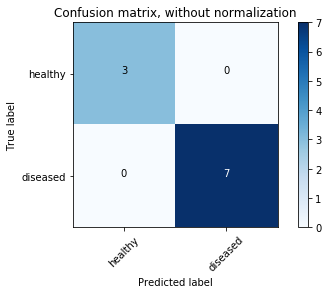

In [13]:
%matplotlib inline


# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["healthy", "diseased"],
                      title='Confusion matrix, without normalization')